In [4]:
import sys; sys.path.append('../');
import Preprocess.preprocessor as preprocessor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [5]:
df_h = preprocessor.ReadData(pth='../Dataset/body_level_classification_train.csv', label='Body_Level')
df_h.head()

,Gender,Age,Height,Weight,H_Cal_Consump,Veg_Consump,Water_Consump,Alcohol_Consump,Smoking,Meal_Count,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Phys_Act,Time_E_Dev,Transport,Body_Level
0,Female,22.547298,1.722461,51.881263,yes,2.663421,1.041110,no,no,3.000000,Frequently,yes,no,0.794402,1.391948,Public_Transportation,Body Level 1
1,Male,19.799054,1.743702,54.927529,yes,2.000000,2.847264,Sometimes,no,3.289260,Sometimes,yes,no,1.680844,2.000000,Public_Transportation,Body Level 1
2,Female,17.823438,1.708406,50.000000,yes,1.642241,1.099231,Sometimes,no,3.452590,Sometimes,no,no,0.418875,1.000000,Public_Transportation,Body Level 1
3,Female,19.007177,1.690727,49.895716,yes,1.212908,1.029703,Sometimes,no,3.207071,Sometimes,no,no,2.000000,1.000000,Public_Transportation,Body Level 1
4,Male,19.729250,1.793315,58.195150,yes,2.508835,2.076933,no,no,3.435905,Sometimes,yes,no,2.026668,1.443328,Automobile,Body Level 1


In [6]:
# add augmented columns like BMI ...
AGGREGATE = True
DISCRETIZE = False
# one hot encoding for categorical columns
ONE_HOT = False
# resample data
RESAMPLE = False
# resmapling using SMOTE
APPLY_SMOTE = False
# Preprocess
df_h = preprocessor.LabelOrdinalEncode(df_h)
if AGGREGATE:
    df_h = preprocessor.Aggregate(df_h, discretize=DISCRETIZE)
if ONE_HOT:
    df_h = preprocessor.OneHotEncode(df_h, label='Body_Level')
if APPLY_SMOTE:
    df_h = preprocessor.SMOTE(df_h)
elif RESAMPLE:
    df_h = preprocessor.Resample(df_h)
#
df_h.head()

,Gender,Age,Height,Weight,H_Cal_Consump,Veg_Consump,Water_Consump,Alcohol_Consump,Smoking,Meal_Count,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Phys_Act,Time_E_Dev,Transport,BMI,Body_Level
0,0,22.547298,1.722461,51.881263,1,2.663421,1.041110,0,0,3.000000,2,1,0,0.794402,1.391948,2,17.486856,0
1,1,19.799054,1.743702,54.927529,1,2.000000,2.847264,1,0,3.289260,1,1,0,1.680844,2.000000,2,18.065315,0
2,0,17.823438,1.708406,50.000000,1,1.642241,1.099231,1,0,3.452590,1,0,0,0.418875,1.000000,2,17.131202,0
3,0,19.007177,1.690727,49.895716,1,1.212908,1.029703,1,0,3.207071,1,0,0,2.000000,1.000000,2,17.454857,0
4,1,19.729250,1.793315,58.195150,1,2.508835,2.076933,0,0,3.435905,1,1,0,2.026668,1.443328,4,18.095627,0


## Learning Curve

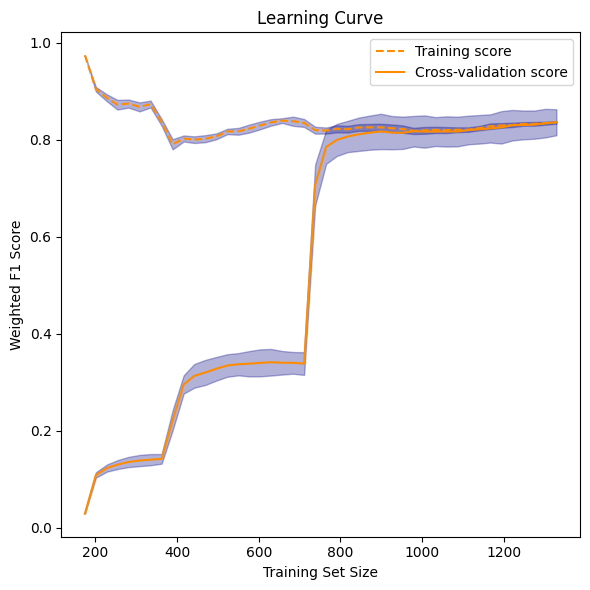

In [61]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(SVC(), df_h.iloc[:,:-1], df_h.iloc[:,-1], 
                                                        cv=10, scoring='f1_weighted', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(6,6))
plt.plot(train_sizes, train_mean, '--', color="darkorange",  label="Training score")
plt.plot(train_sizes, test_mean, color="darkorange", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="navy", alpha=0.3)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.3)

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted F1 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = preprocessor.Split(df_h, test_size=0.2, random_state=0)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

print(f'{X_train.head()=}')
print(f'{y_train.head()=}')

X_train.shape:  (1181, 17)
X_test.shape:  (296, 17)
y_train.shape:  (1181,)
y_test.shape:  (296,)
X_train.head()=      Gender        Age    Height      Weight  H_Cal_Consump  Veg_Consump  \
1149       0  23.000000  1.644161   84.340406              1     2.177243   
1469       1  31.868930  1.750000  118.102897              1     2.139196   
56         0  21.287999  1.555778   42.360100              0     2.318355   
1120       0  26.000000  1.624950  111.004920              1     3.000000   
467        1  33.000000  1.850000   93.000000              1     2.000000   

      Water_Consump  Alcohol_Consump  Smoking  Meal_Count  Food_Between_Meals  \
1149       2.715572                0        0    3.000000                   1   
1469       2.048430                1        0    3.000000                   1   
56         1.220365                0        0    1.082304                   2   
1120       2.704315                1        0    3.000000                   1   
467        1.000000

In [8]:
scorer = make_scorer(f1_score, average='weighted')

def analyze_grid(grid, X_train, X_test, name):
    # print best parameter after tuning
    print(grid.best_params_)
    print(grid.best_estimator_)

    y_pred_train = grid.predict(X_train)
    y_pred = grid.predict(X_test)

    print(f'Training Metrics for {name}:')
    # print(classification_report(y_train, y_pred_train, digits=4))
    print(confusion_matrix(y_train, y_pred_train))
    # print(confusion_matrix(y_train, y_pred_train, normalize='true'))

    # print(classification_report(y_train, y_pred_train, digits=4).split('\n')[-2])
    # print(classification_report(y_test, y_pred, digits=4).split('\n')[-2])

    print(f'\nTesting Metrics for {name}:')
    print(classification_report(y_test, y_pred, digits=4))
    print(confusion_matrix(y_test, y_pred))
    # print(confusion_matrix(y_test, y_pred, normalize='true'))

In [42]:
!mkdir Results/

The syntax of the command is incorrect.


# SVM

## Validation Curve with SVM Gamma

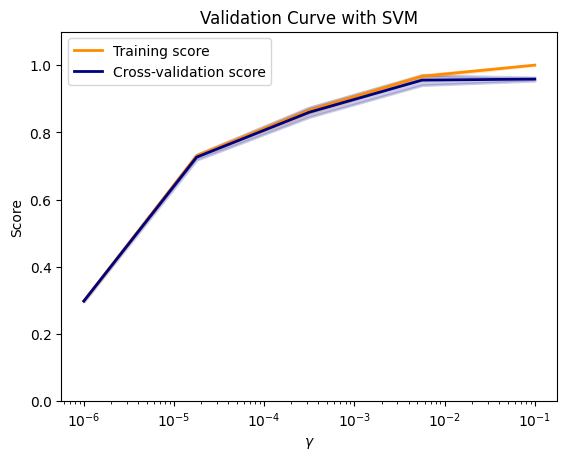

In [43]:

from sklearn.model_selection import validation_curve

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(),
    X_train,
    y_train,
    param_name="gamma",
    param_range=param_range,
    scoring="f1_weighted",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## Cross Validation with SVM C

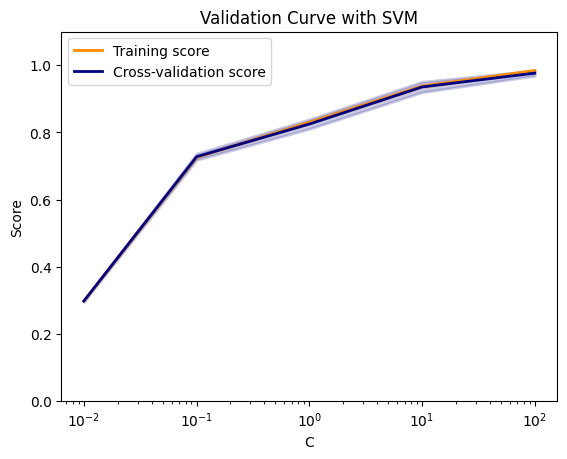

In [44]:

from sklearn.model_selection import validation_curve

param_range = np.logspace(-2, 2, 5)
train_scores, test_scores = validation_curve(
    SVC(),
    X_train,
    y_train,
    param_name="C",
    param_range=param_range,
    scoring="f1_weighted",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [47]:
# GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# SVM
# 'C': [0.1, 1, 3, 5, 7, 10, 12, 14, 15],
# 'gamma': [1, 0.1, 0.01, 0.001],
param_grid = {'C': [0.1, 1, 3, 5, 7, 10, 12, 14, 15, 50, 100],
                'gamma': [1, 0.1, 0.01],
                'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, scoring=scorer)
grid.fit(X_train, y_train)
# output the cv result to csv
pd.DataFrame(grid.cv_results_).to_csv('Results/svm_grid_search_cv.csv')


In [48]:
analyze_grid(grid, X_train, X_test, name='SVM')

{'C': 12, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=12, gamma=0.01)
Training Metrics for SVM:
[[150   0   0   0]
 [  0 160   0   0]
 [  0   0 319   0]
 [  0   0   0 552]]

Testing Metrics for SVM:
              precision    recall  f1-score   support

           0     0.9524    1.0000    0.9756        40
           1     0.9750    0.9512    0.9630        41
           2     1.0000    0.9885    0.9942        87
           3     1.0000    1.0000    1.0000       128

    accuracy                         0.9899       296
   macro avg     0.9818    0.9849    0.9832       296
weighted avg     0.9901    0.9899    0.9899       296

[[ 40   0   0   0]
 [  2  39   0   0]
 [  0   1  86   0]
 [  0   0   0 128]]


# Random Forest

## Validation Curve with n_estimators

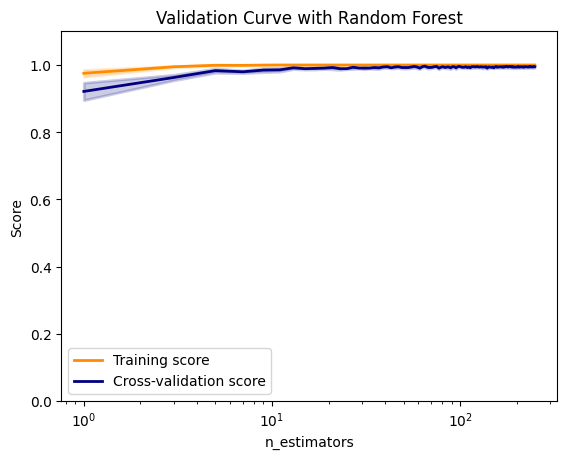

In [50]:

from sklearn.model_selection import validation_curve

param_range = np.arange(1, 250, 2)

train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                X_train, y_train, param_name="n_estimators", param_range=param_range,
                                cv=4, scoring="f1_weighted", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [51]:
# Random Forest
param_grid = {'n_estimators': [10, 50, 100, 200],
                'max_features': ['sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8, 12, 16],
                'criterion' :['gini', 'entropy']}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, cv=5, scoring=scorer)
grid.fit(X_train, y_train)
# output cv results to csv
pd.DataFrame(grid.cv_results_).to_csv( 'Results/random_forest_grid_search_results.csv')

In [52]:
analyze_grid(grid, X_train, X_test, name='Random Forest')

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}
RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=200)
Training Metrics for Random Forest:
[[150   0   0   0]
 [  0 160   0   0]
 [  0   0 319   0]
 [  0   0   0 552]]

Testing Metrics for Random Forest:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     0.9762    1.0000    0.9880        41
           2     1.0000    0.9770    0.9884        87
           3     0.9922    1.0000    0.9961       128

    accuracy                         0.9932       296
   macro avg     0.9921    0.9943    0.9931       296
weighted avg     0.9933    0.9932    0.9932       296

[[ 40   0   0   0]
 [  0  41   0   0]
 [  0   1  85   1]
 [  0   0   0 128]]


# LightGBM

In [22]:
# LightGBM
param_grid = {
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'learning_rate': [0.05, 0.1, 0.2, .3, .5],
    # 'n_estimators': [50, 100, 200, 500],
    'n_estimators': [100, 500, 1000],
    # 'num_leaves': [4, 8, 16, 32, 64],
    # 'num_leaves': [32, 64],
    # 'max_depth': [4, 5, 6, 7, 8, 12, 16],
    # 'max_depth': [12, 16],
    'boosting_type' : ['gbdt', 'dart', 'goss'],
    'objective' : ['multiclass'],
    # 'random_state' : [501],
    # 'colsample_bytree' : [0.65, 0.66],
    # 'subsample' : [0.7,0.75],
    # 'reg_alpha' : [0.001, 1, 2.0],
    # 'reg_lambda' : [0.001, 1, 2.0],
}
grid = GridSearchCV(LGBMClassifier(), param_grid, refit=True, cv=5, scoring=scorer)
grid.fit(X_train, y_train)
# output cv results to csv
pd.DataFrame(grid.cv_results_).to_csv( 'Results/lightGBM_grid_search_results.csv')

In [24]:
analyze_grid(grid, X_train, X_test, name='LightGBM')

{'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 500, 'objective': 'multiclass'}
LGBMClassifier(boosting_type='dart', n_estimators=500, objective='multiclass')
Training Metrics for LightGBM:
[[159   0   0   0]
 [  0 156   0   0]
 [  0   0 324   0]
 [  0   0   0 542]]

Testing Metrics for LightGBM:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        31
           1     1.0000    1.0000    1.0000        45
           2     0.9878    0.9878    0.9878        82
           3     0.9928    0.9928    0.9928       138

    accuracy                         0.9932       296
   macro avg     0.9951    0.9951    0.9951       296
weighted avg     0.9932    0.9932    0.9932       296

[[ 31   0   0   0]
 [  0  45   0   0]
 [  0   0  81   1]
 [  0   0   1 137]]


# XGBoost

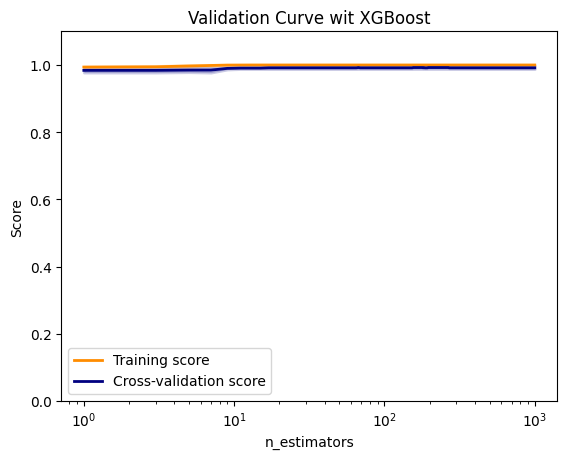

In [53]:

from sklearn.model_selection import validation_curve

param_range = np.arange(1, 1000, 2)

train_scores, test_scores = validation_curve(XGBClassifier(),
                                X_train, y_train, param_name="n_estimators", param_range=param_range,
                                cv=4, scoring="f1_weighted", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve wit XGBoost")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [54]:
# XGBoost
param_grid = {
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'learning_rate': [0.05, 0.1, 0.2, .3],
    # 'n_estimators': [10, 50, 100, 200, 500],
    'n_estimators': [100, 1000],
    # 'max_depth': [4, 5, 6, 7, 8, 12, 16],
    # 'max_depth': [4, 8, 12, 16],
    # 'booster' : ['gbtree', 'gblinear', 'dart'],
    'objective' : ['multi:softmax'],
    # 'random_state' : [501], # Updated from 'seed'
    # 'colsample_bytree' : [0.65, 0.66],
    # 'subsample' : [0.7,0.75],
    'reg_alpha' : [.1, 1,1.2, 2],
    'reg_lambda' : [.1, 1,1.2,1.4, 2],
}

grid = GridSearchCV(XGBClassifier(), param_grid, refit=True, cv=5, scoring=scorer)
grid.fit(X_train, y_train)
# output cv results to csv
pd.DataFrame(grid.cv_results_).to_csv( 'Results/XGBoost_grid_search_results.csv')

In [55]:
analyze_grid(grid, X_train, X_test, name='XGBoost')

{'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'multi:softmax', 'reg_alpha': 0.1, 'reg_lambda': 2}
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)
Training Metrics for XGBoost:
[[150   0   0   0]
 [  0 160   0   0]
 [  0   0 319   0]
 [  0   0   0 552]]

Testing Metrics for XGBo